In [2]:
%run imports.ipynb
# make sure that the file imports.ipynb is in the same folder as this notebook

### Making file for radii of planets around small cool stars


In [3]:
workingTableExoplanets = pandas.read_pickle("../data/MRP_data_sets.pkl")

workingTableExoplanets = workingTableExoplanets.query("`radius-1`.notna() & `radius-2`.notna()")
workingTableExoplanets = workingTableExoplanets.query("`radius_error_min-1`.notna() & `radius_error_max-1`.notna() & `radius_error_min-2`.notna() & `radius_error_max-2`")
workingTableExoplanets = workingTableExoplanets.query("`pl_radjlim`.isnull()")
planetstodrop = []

for index, row in workingTableExoplanets.iterrows():
    if (abs(workingTableExoplanets.at[index,"radius_error_min-1"]) + workingTableExoplanets.at[index,"radius_error_max-1"])/workingTableExoplanets.at[index,"radius-1"] >= 2.0:
        planetstodrop.append(index)
    if (abs(workingTableExoplanets.at[index,"radius_error_min-2"]) + workingTableExoplanets.at[index,"radius_error_max-2"])/workingTableExoplanets.at[index,"radius-2"] >= 2.0:
        planetstodrop.append(index)
print(len(planetstodrop))

workingTableExoplanets = workingTableExoplanets.drop(index=planetstodrop)


tablePlan = workingTableExoplanets.query("`star_radius` <1.")
tablePlan = tablePlan.query("`star_mass` <1.")
tablePlan = tablePlan.query("`star_teff` <5777.")


tablePlan = tablePlan.sort_values("star_mass")
tablePlan =tablePlan.head(40)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tablePlan)
tablePlan.to_pickle("../data/lowMRT_rad.pkl")


2


,granule_uid-1,radius-1,radius_error_min-1,radius_error_max-1,mass-1,mass_error_min-1,mass_error_max-1,semi_major_axis-1,semi_major_axis_error_min-1,semi_major_axis_error_max-1,period-1,period_error_min-1,period_error_max-1,granule_uid-2,radius-2,radius_error_min-2,radius_error_max-2,mass-2,mass_error_min-2,mass_error_max-2,semi_major_axis-2,semi_major_axis_error_min-2,semi_major_axis_error_max-2,period-2,period_error_min-2,period_error_max-2,star_teff,star_radius,star_mass,star_metallicity,star_age,st_rotp,sy_snum,cb_flag,sy_pnum,pl_radjlim,pl_massjlim,mass_detection_type,star_name
TRAPPIST-1-6,TRAPPIST-1 g,0.10050,0.00370,0.003700,0.00422,0.00280,0.00280,0.04510,0.00140,0.00140,12.352940,1.200000e-04,1.200000e-04,TRAPPIST-1 h,0.06740,0.00300,0.00300,0.00103,0.00006,0.00006,0.06300,0.01300,0.02700,20.000000,6.000000,15.000000,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-4,TRAPPIST-1 e,0.08190,0.00350,0.003500,0.00200,0.00180,0.00180,0.02817,0.00087,0.00083,6.099615,1.100000e-05,1.100000e-05,TRAPPIST-1 f,0.09323,0.00340,0.00340,0.00210,0.00057,0.00057,0.03710,0.00110,0.00110,9.206690,0.000015,0.000015,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-3,TRAPPIST-1 d,0.06890,0.00270,0.002700,0.00130,0.00085,0.00085,0.02144,0.00063,0.00066,4.049610,6.300000e-05,6.300000e-05,TRAPPIST-1 e,0.08190,0.00350,0.00350,0.00200,0.00180,0.00180,0.02817,0.00087,0.00083,6.099615,0.000011,0.000011,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-2,TRAPPIST-1 c,0.09421,0.00031,0.000310,0.00434,0.00190,0.00190,0.01521,0.00047,0.00047,2.421823,1.700000e-06,1.700000e-06,TRAPPIST-1 d,0.06890,0.00270,0.00270,0.00130,0.00085,0.00085,0.02144,0.00063,0.00066,4.049610,0.000063,0.000063,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-1,TRAPPIST-1 b,0.09689,0.00031,0.000310,0.00270,0.00230,0.00230,0.01111,0.00034,0.00034,1.510871,6.000000e-05,6.000000e-05,TRAPPIST-1 c,0.09421,0.00031,0.00031,0.00434,0.00190,0.00190,0.01521,0.00047,0.00047,2.421823,0.000002,0.000002,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-5,TRAPPIST-1 f,0.09323,0.00340,0.003400,0.00210,0.00057,0.00057,0.03710,0.00110,0.00110,9.206690,1.500000e-05,1.500000e-05,TRAPPIST-1 g,0.10050,0.00370,0.00370,0.00422,0.00280,0.00280,0.04510,0.00140,0.00140,12.352940,0.000120,0.000120,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
Kepler-42-2,Kepler-42 b,0.07000,0.02000,0.020000,0.00900,NaN,NaN,0.01130,0.00055,0.00055,1.213767,4.600000e-06,4.600000e-06,Kepler-42 d,0.05100,0.01600,0.01600,0.00300,NaN,NaN,0.01510,0.00073,0.00073,1.865169,0.000014,0.000014,3068.0,0.170,0.130,-0.33,4.500,NaN,1.0,NaN,3.0,NaN,NaN,,Kepler-42
Kepler-42-1,Kepler-42 c,0.06500,0.01800,0.018000,0.00600,NaN,NaN,0.00590,0.00028,0.00028,0.453285,9.700000e-07,9.700000e-07,Kepler-42 b,0.07000,0.02000,0.02000,0.00900,NaN,NaN,0.01130,0.00055,0.00055,1.213767,0.000005,0.000005,3068.0,0.170,0.130,-0.33,4.500,NaN,1.0,NaN,3.0,NaN,NaN,,Kepler-42
LHS 1140-1,LHS 1140 c,0.10400,0.00300,0.003000,0.00554,0.00050,0.00053,0.02675,0.00070,0.00070,3.777931,3.000000e-06,3.000000e-06,LHS 1140 b,0.14600,0.00400,0.00400,0.02007,0.00138,0.00145,0.09360,0.00240,0.00240,24.736000,0.000250,0.000250,3131.0,0.186,0.146,-0.24,5.000,131.00,1.0,NaN,2.0,NaN,NaN,Radial Velocity,LHS 1140
Kepler-445-1,Kepler-445 b,0.14000,0.02000,0.020000,0.02000,0.00300,0.00300,0.02170,NaN,NaN,2.984151,1.100000e-05,1.100000e-05,Kepler-445 c,0.22000,0.03000,0.03000,0.02700,0.00200,0.00200,0.03010,NaN,NaN,4.871229,0.000011,0.000011,3157.0,0.210,0.180,0.27,6.610,NaN,1.0,NaN,3.0,NaN,NaN,Theoretical,Kepler-445


### Calculating the Pearson correlation coefficients for certain stellar parameter range and performing the bootsrap test by choosing random 40 pairs from the entire sample

This cell makes use of .pkl files saved after running MRD_adjacent_planets.py which contain unusually correlated subsample. Such a file will look like that: "./data/80_0.8793810742432698_star_age_radius.pkl", and first part "80" indicates at which x this subsample starts within the main sample, and numbers after underscore like "0.879..." will indicate the R-value of the subsample

,granule_uid-1,radius-1,radius_error_min-1,radius_error_max-1,mass-1,mass_error_min-1,mass_error_max-1,semi_major_axis-1,semi_major_axis_error_min-1,semi_major_axis_error_max-1,period-1,period_error_min-1,period_error_max-1,granule_uid-2,radius-2,radius_error_min-2,radius_error_max-2,mass-2,mass_error_min-2,mass_error_max-2,semi_major_axis-2,semi_major_axis_error_min-2,semi_major_axis_error_max-2,period-2,period_error_min-2,period_error_max-2,star_teff,star_radius,star_mass,star_metallicity,star_age,st_rotp,sy_snum,cb_flag,sy_pnum,pl_radjlim,pl_massjlim,mass_detection_type,star_name
TRAPPIST-1-6,TRAPPIST-1 g,0.10050,0.00370,0.003700,0.00422,0.00280,0.00280,0.04510,0.00140,0.00140,12.352940,1.200000e-04,1.200000e-04,TRAPPIST-1 h,0.06740,0.00300,0.00300,0.00103,0.00006,0.00006,0.06300,0.01300,0.02700,20.000000,6.000000,15.000000,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-4,TRAPPIST-1 e,0.08190,0.00350,0.003500,0.00200,0.00180,0.00180,0.02817,0.00087,0.00083,6.099615,1.100000e-05,1.100000e-05,TRAPPIST-1 f,0.09323,0.00340,0.00340,0.00210,0.00057,0.00057,0.03710,0.00110,0.00110,9.206690,0.000015,0.000015,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-3,TRAPPIST-1 d,0.06890,0.00270,0.002700,0.00130,0.00085,0.00085,0.02144,0.00063,0.00066,4.049610,6.300000e-05,6.300000e-05,TRAPPIST-1 e,0.08190,0.00350,0.00350,0.00200,0.00180,0.00180,0.02817,0.00087,0.00083,6.099615,0.000011,0.000011,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-2,TRAPPIST-1 c,0.09421,0.00031,0.000310,0.00434,0.00190,0.00190,0.01521,0.00047,0.00047,2.421823,1.700000e-06,1.700000e-06,TRAPPIST-1 d,0.06890,0.00270,0.00270,0.00130,0.00085,0.00085,0.02144,0.00063,0.00066,4.049610,0.000063,0.000063,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-1,TRAPPIST-1 b,0.09689,0.00031,0.000310,0.00270,0.00230,0.00230,0.01111,0.00034,0.00034,1.510871,6.000000e-05,6.000000e-05,TRAPPIST-1 c,0.09421,0.00031,0.00031,0.00434,0.00190,0.00190,0.01521,0.00047,0.00047,2.421823,0.000002,0.000002,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-5,TRAPPIST-1 f,0.09323,0.00340,0.003400,0.00210,0.00057,0.00057,0.03710,0.00110,0.00110,9.206690,1.500000e-05,1.500000e-05,TRAPPIST-1 g,0.10050,0.00370,0.00370,0.00422,0.00280,0.00280,0.04510,0.00140,0.00140,12.352940,0.000120,0.000120,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
Kepler-42-2,Kepler-42 b,0.07000,0.02000,0.020000,0.00900,NaN,NaN,0.01130,0.00055,0.00055,1.213767,4.600000e-06,4.600000e-06,Kepler-42 d,0.05100,0.01600,0.01600,0.00300,NaN,NaN,0.01510,0.00073,0.00073,1.865169,0.000014,0.000014,3068.0,0.170,0.130,-0.33,4.500,NaN,1.0,NaN,3.0,NaN,NaN,,Kepler-42
Kepler-42-1,Kepler-42 c,0.06500,0.01800,0.018000,0.00600,NaN,NaN,0.00590,0.00028,0.00028,0.453285,9.700000e-07,9.700000e-07,Kepler-42 b,0.07000,0.02000,0.02000,0.00900,NaN,NaN,0.01130,0.00055,0.00055,1.213767,0.000005,0.000005,3068.0,0.170,0.130,-0.33,4.500,NaN,1.0,NaN,3.0,NaN,NaN,,Kepler-42
LHS 1140-1,LHS 1140 c,0.10400,0.00300,0.003000,0.00554,0.00050,0.00053,0.02675,0.00070,0.00070,3.777931,3.000000e-06,3.000000e-06,LHS 1140 b,0.14600,0.00400,0.00400,0.02007,0.00138,0.00145,0.09360,0.00240,0.00240,24.736000,0.000250,0.000250,3131.0,0.186,0.146,-0.24,5.000,131.00,1.0,NaN,2.0,NaN,NaN,Radial Velocity,LHS 1140
Kepler-445-1,Kepler-445 b,0.14000,0.02000,0.020000,0.02000,0.00300,0.00300,0.02170,NaN,NaN,2.984151,1.100000e-05,1.100000e-05,Kepler-445 c,0.22000,0.03000,0.03000,0.02700,0.00200,0.00200,0.03010,NaN,NaN,4.871229,0.000011,0.000011,3157.0,0.210,0.180,0.27,6.610,NaN,1.0,NaN,3.0,NaN,NaN,Theoretical,Kepler-445


Upper side of the line, planets: 22 , part: 0.55
Lower side of the line, planets: 18 , part: 0.45
On the line, planets: 0


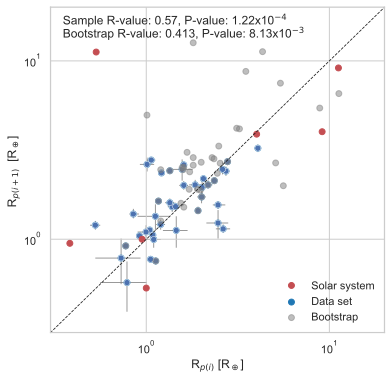

In [4]:
workingTableExoplanets = workingTableExoplanets.sort_values("star_name")

# load file either for small cool star as stated there or one of .pkl resulting from running MRD_adjacent_planets.py.

tableEX1 =pandas.read_pickle("../data/lowMRT_rad.pkl")
# displaying the subsample
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tableEX1)

resultsExoplanetsm2 = tableEX1.query("`radius-2` > `radius-1`")
resultsExoplanetsm1 = tableEX1.query("`radius-2` < `radius-1`")
resultsExoplanetsmeq = tableEX1.query("`radius-2` == `radius-1`")

radius_1 = tableEX1["radius-1"] * radius_coeff
radius_2 = tableEX1["radius-2"] * radius_coeff
star_age = tableEX1["star_age"]
star_teff = tableEX1["star_teff"]
star_mass = tableEX1["star_mass"]
star_radius = tableEX1["star_radius"]
star_metallicity = tableEX1["star_metallicity"]
star_rotp = tableEX1["st_rotp"]

print(f'Upper side of the line, planets:', len(resultsExoplanetsm2), ', part:', numpy.round(len(resultsExoplanetsm2)/ len(tableEX1), 3))
print(f'Lower side of the line, planets:', len(resultsExoplanetsm1), ', part:', numpy.round(len(resultsExoplanetsm1)/ len(tableEX1), 3))
print(f'On the line, planets:', len(resultsExoplanetsmeq))

pearson_coef, p_value = stats.pearsonr(radius_1, radius_2) #define the columns to perform calculations on

seaborn.set_theme(style="whitegrid")
plt.rcParams['figure.figsize']=(6,6)
cmap = seaborn.cubehelix_palette(rot=-.3, as_cmap=True)
g = seaborn.scatterplot(
    x=radius_1, y=radius_2,
    legend=False,
    palette=cmap
)
g.set(xscale="log", yscale="log")

g.set(ylim=(0.3, 20))
g.set(xlim=(0.3, 20))
x = numpy.linspace(0.001, 5000, 2000)
y = x
plt.plot(x, y, linewidth=0.8, linestyle='--', color='k')
xerr = numpy.nan_to_num(tableEX1[["radius_error_min-1", "radius_error_max-1"]].to_numpy().T, posinf=0.) * radius_coeff
yerr = numpy.nan_to_num(tableEX1[["radius_error_min-2", "radius_error_max-2"]].to_numpy().T, posinf=0.) * radius_coeff
def decimal(b):
    a = numpy.log10(b)
    frac1, whole1 = math.modf(a)
    b2 = whole1 - 1
    b1 = b * 10 ** abs(b2)
    return b1, b2
p_value1, p_value2 = decimal(p_value)
plt.errorbar(radius_1, radius_2, xerr=numpy.abs(xerr), yerr=numpy.abs(yerr), ls='none', fmt='0.8', ecolor='tab:gray', elinewidth=0.8, capsize=None, barsabove=True, zorder=0)
plt.scatter(radius_1, radius_2, marker="o", facecolor='tab:blue', zorder=0, label="Data set")

plt.text(0.35, 16,f"Sample R-value: {(pearson_coef).round(3)}, P-value: {p_value1.round(2)}x10$^{{{round(p_value2)}}}$", fontsize=12)
solarsystemTable = pandas.read_pickle("../data/solarsystemE.pkl")
radiusS = solarsystemTable["radiusJ"] * radius_coeff

for i in range(len(radiusS)-1):
    if i == 1:
        plt.plot(radiusS[i], radiusS[i+1], 'ro', ms=6, zorder=1, label="Solar system")
    else:
        plt.plot(radiusS[i], radiusS[i+1], 'ro', ms=6, zorder=1)

bootstrap = workingTableExoplanets.sample(n=40)
plt.scatter(bootstrap["radius-1"] * radius_coeff, bootstrap["radius-2"] * radius_coeff,
            facecolor ='tab:gray', alpha = 0.5, zorder=1, label="Bootstrap")

pearson_coefB, p_valueB = stats.pearsonr(bootstrap["radius-1"]* radius_coeff, bootstrap["radius-2"]* radius_coeff)

p_valueB1, p_valueB2 = decimal(p_valueB)
plt.text(0.35, 13.5,f"Bootstrap R-value: {(pearson_coefB).round(3)}, P-value: {p_valueB1.round(2)}x10$^{{{round(p_valueB2)}}}$", fontsize=12)
plt.xlabel(r"R$_{p(i)}$ [R$_\oplus$]")
plt.ylabel(r"R$_{p(i+1)}$  [R$_\oplus$] ")
plt.legend(loc="lower right", frameon=False)

plt.savefig("sample40_radius_lowMRT.png",bbox_inches="tight")
plt.savefig("sample40_radius_lowMRT.svg",bbox_inches="tight")

## Calculating the Pearson coefficients distrobutions, mean, median values from 10$^5$ error accomodation simulations for a certain sub-sample planets

,granule_uid-1,radius-1,radius_error_min-1,radius_error_max-1,mass-1,mass_error_min-1,mass_error_max-1,semi_major_axis-1,semi_major_axis_error_min-1,semi_major_axis_error_max-1,period-1,period_error_min-1,period_error_max-1,granule_uid-2,radius-2,radius_error_min-2,radius_error_max-2,mass-2,mass_error_min-2,mass_error_max-2,semi_major_axis-2,semi_major_axis_error_min-2,semi_major_axis_error_max-2,period-2,period_error_min-2,period_error_max-2,star_teff,star_radius,star_mass,star_metallicity,star_age,st_rotp,sy_snum,cb_flag,sy_pnum,pl_radjlim,pl_massjlim,mass_detection_type,star_name
TRAPPIST-1-6,TRAPPIST-1 g,0.10050,0.00370,0.003700,0.00422,0.00280,0.00280,0.04510,0.00140,0.00140,12.352940,1.200000e-04,1.200000e-04,TRAPPIST-1 h,0.06740,0.00300,0.00300,0.00103,0.00006,0.00006,0.06300,0.01300,0.02700,20.000000,6.000000,15.000000,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-4,TRAPPIST-1 e,0.08190,0.00350,0.003500,0.00200,0.00180,0.00180,0.02817,0.00087,0.00083,6.099615,1.100000e-05,1.100000e-05,TRAPPIST-1 f,0.09323,0.00340,0.00340,0.00210,0.00057,0.00057,0.03710,0.00110,0.00110,9.206690,0.000015,0.000015,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-3,TRAPPIST-1 d,0.06890,0.00270,0.002700,0.00130,0.00085,0.00085,0.02144,0.00063,0.00066,4.049610,6.300000e-05,6.300000e-05,TRAPPIST-1 e,0.08190,0.00350,0.00350,0.00200,0.00180,0.00180,0.02817,0.00087,0.00083,6.099615,0.000011,0.000011,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-2,TRAPPIST-1 c,0.09421,0.00031,0.000310,0.00434,0.00190,0.00190,0.01521,0.00047,0.00047,2.421823,1.700000e-06,1.700000e-06,TRAPPIST-1 d,0.06890,0.00270,0.00270,0.00130,0.00085,0.00085,0.02144,0.00063,0.00066,4.049610,0.000063,0.000063,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-1,TRAPPIST-1 b,0.09689,0.00031,0.000310,0.00270,0.00230,0.00230,0.01111,0.00034,0.00034,1.510871,6.000000e-05,6.000000e-05,TRAPPIST-1 c,0.09421,0.00031,0.00031,0.00434,0.00190,0.00190,0.01521,0.00047,0.00047,2.421823,0.000002,0.000002,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
TRAPPIST-1-5,TRAPPIST-1 f,0.09323,0.00340,0.003400,0.00210,0.00057,0.00057,0.03710,0.00110,0.00110,9.206690,1.500000e-05,1.500000e-05,TRAPPIST-1 g,0.10050,0.00370,0.00370,0.00422,0.00280,0.00280,0.04510,0.00140,0.00140,12.352940,0.000120,0.000120,2560.0,0.117,0.080,0.04,7.600,1.40,1.0,NaN,7.0,NaN,NaN,TTV,TRAPPIST-1
Kepler-42-2,Kepler-42 b,0.07000,0.02000,0.020000,0.00900,NaN,NaN,0.01130,0.00055,0.00055,1.213767,4.600000e-06,4.600000e-06,Kepler-42 d,0.05100,0.01600,0.01600,0.00300,NaN,NaN,0.01510,0.00073,0.00073,1.865169,0.000014,0.000014,3068.0,0.170,0.130,-0.33,4.500,NaN,1.0,NaN,3.0,NaN,NaN,,Kepler-42
Kepler-42-1,Kepler-42 c,0.06500,0.01800,0.018000,0.00600,NaN,NaN,0.00590,0.00028,0.00028,0.453285,9.700000e-07,9.700000e-07,Kepler-42 b,0.07000,0.02000,0.02000,0.00900,NaN,NaN,0.01130,0.00055,0.00055,1.213767,0.000005,0.000005,3068.0,0.170,0.130,-0.33,4.500,NaN,1.0,NaN,3.0,NaN,NaN,,Kepler-42
LHS 1140-1,LHS 1140 c,0.10400,0.00300,0.003000,0.00554,0.00050,0.00053,0.02675,0.00070,0.00070,3.777931,3.000000e-06,3.000000e-06,LHS 1140 b,0.14600,0.00400,0.00400,0.02007,0.00138,0.00145,0.09360,0.00240,0.00240,24.736000,0.000250,0.000250,3131.0,0.186,0.146,-0.24,5.000,131.00,1.0,NaN,2.0,NaN,NaN,Radial Velocity,LHS 1140
Kepler-445-1,Kepler-445 b,0.14000,0.02000,0.020000,0.02000,0.00300,0.00300,0.02170,NaN,NaN,2.984151,1.100000e-05,1.100000e-05,Kepler-445 c,0.22000,0.03000,0.03000,0.02700,0.00200,0.00200,0.03010,NaN,NaN,4.871229,0.000011,0.000011,3157.0,0.210,0.180,0.27,6.610,NaN,1.0,NaN,3.0,NaN,NaN,Theoretical,Kepler-445


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Median=0.565
Median=-3.832
Meandata1=0.00019050447328677073


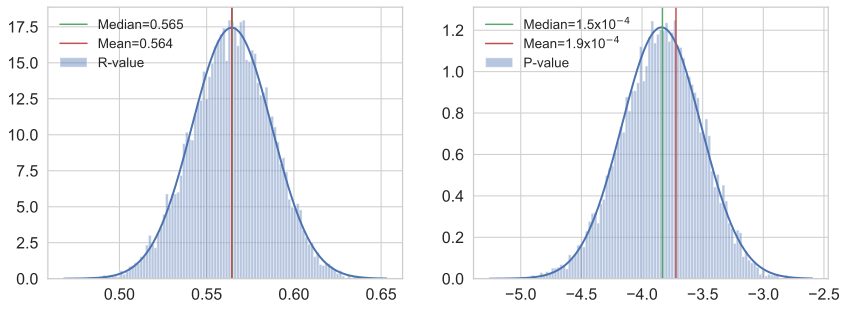

In [5]:
# load file either for small cool star as stated there or one of .pkl resulting from running MRD_adjacent_planets.py
tableEX =pandas.read_pickle("../data/lowMRT_rad.pkl")
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(tableEX)

counts = 10000

radius_erD1 = numpy.zeros((len(tableEX), counts))
radius_erD2 = numpy.zeros((len(tableEX), counts))

j = 0
for index, row in tableEX.iterrows():

    radiusExo1 = []
    radiusExo2 = []
    upperLimitradius1 = (row["radius_error_max-1"] + row["radius-1"])  * radius_coeff
    lowerLimitradius1 = (row["radius-1"] - abs(row["radius_error_min-1"])) * radius_coeff
    # print(upperLimitradius1, lowerLimitradius1)
    radiusExo1 = numpy.random.uniform(upperLimitradius1, lowerLimitradius1, counts)
    radius_erD1[j] = radiusExo1

    upperLimitradius2 = (row["radius_error_max-2"] + row["radius-2"])  * radius_coeff
    lowerLimitradius2 = (row["radius-2"] - abs(row["radius_error_min-2"])) * radius_coeff
    radiusExo2 = numpy.random.uniform(upperLimitradius2, lowerLimitradius2, counts)
    radius_erD2[j] = radiusExo2
    j +=1


pearsonmassive = []
pvaluemassive = []


for i in range(counts):
    pearson_coef = 0.
    p_value = 0.
    y1 = []
    x1 = []
    for k in range(len(tableEX)):
        y1.append(radius_erD2[k][i])
        x1.append(radius_erD1[k][i])
    pearson_coef, p_value = stats.pearsonr(x1, y1)


    pearsonmassive.append(pearson_coef)
    pvaluemassive.append(p_value)

fig, ax = plt.subplots(1,2,figsize=(14,5))

data = numpy.array(pearsonmassive)

seaborn.set(rc={'figure.figsize':(14,5)})

seaborn.cubehelix_palette(start=-.2,rot=.6, as_cmap=True)
seaborn.set_theme(style="whitegrid")

h = seaborn.distplot(data, hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[0], label=f"R-value")

data1 = numpy.array(pvaluemassive)

h1 = seaborn.distplot(numpy.log10(data1), hist=True, norm_hist=True, kde=False, fit=norm, fit_kws={"color": "b", "lw": 2},bins=100, hist_kws={"weights":None, "density":True, "color": "b"}, ax=ax[1], label=f"P-value")

e = data.mean()
d = numpy.log10(data1.mean())
c=numpy.median(data)
b=numpy.log10(numpy.median(data1))

print(f"Median={c.round(3)}")
ax[0].axvline(x=c,color='g', label=f"Median={format(c,'.3f')}")
ax[0].axvline(x=e,color='r', label=f"Mean={format(e,'.3f')}")

frac1, whole1 = math.modf(b)
b2 = whole1 - 1
b1 = numpy.median(data1) * 10 ** abs(b2)
ax[1].axvline(x=b,color='g', label=f"Median={b1.round(1)}x10$^{{{round(b2)}}}$")
frac2, whole2 = math.modf(d)
d2 = whole2 - 1
d1 = data1.mean() * 10 ** abs(d2)
ax[1].axvline(x=d,color='r', label=f"Mean={d1.round(1)}x10$^{{{round(d2)}}}$")
print(f"Median={b.round(3)}")
print(f"Meandata1={data1.mean()}")

ax[0].legend(loc="upper left", prop={"size":13.5},frameon=False)
ax[1].legend(loc="upper left", prop={"size":13.5},frameon=False)
ax[0].tick_params(axis='both', which='major', labelsize=16)

ax[1].tick_params(axis='both', which='major', labelsize=16)

plt.savefig("Star_chunks_Pearson_dist_radius.png",bbox_inches="tight")
plt.savefig("Star_chunks_Pearson_dist_radius.svg",bbox_inches="tight")
#
# plt.savefig("Star_chunks_Pearson_dist_radiuslow.png",bbox_inches="tight")
# plt.savefig("Star_chunks_Pearson_dist_radiuslow.svg",bbox_inches="tight")

Pearson Correlation Coefficient for data:  0.5703087670750784 and a P-value of: 0.00012204319398828745
R-value median for Bootstrap: 0.552772460655846
P-value median for Bootstrap: 0.00021663989108406496


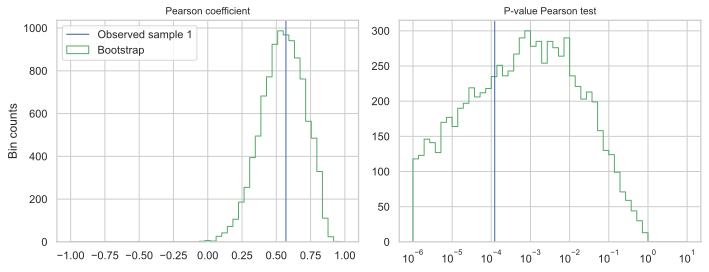

In [6]:
chunk_data = pandas.read_pickle("../data/lowMRT_rad.pkl")
radius_chunk1 = chunk_data["radius-1"] * radius_coeff
radius_chunk2 = chunk_data["radius-2"] * radius_coeff

pearson_coef1, p_value1 = stats.pearsonr(radius_chunk1, radius_chunk2)
print("Pearson Correlation Coefficient for data: ", pearson_coef1, "and a P-value of:", p_value1) # Results

## if you have another unusual correlated sub-sumple, uncomment below and load one of .pkl resulting from running MRD_adjacent_planets.py
# chunk_data1 = pandas.read_pickle("../data/80_0.8793810742432698_star_age_radius.pkl")
# with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(chunk_data1.sort_values("star_age"))
# radius_chunk11 = chunk_data1["radius-1"] * radius_coeff
# radius_chunk12 = chunk_data1["radius-2"] * radius_coeff
# pearson_coef2, p_value2 = stats.pearsonr(radius_chunk11, radius_chunk12)
# print("Pearson Correlation Coefficient for data: ", pearson_coef2, "and a P-value of:", p_value2) # Results

Pearson = []
PvalPe = []

for i in range(10000):
    pearson_coef = 0.
    p_value = 0.

    newtable =  workingTableExoplanets.sample(n=40)



    radius_1 = newtable["radius-1"] * radius_coeff
    radius_2 = newtable["radius-2"] * radius_coeff


    pearson_coef, p_value = stats.pearsonr(radius_1, radius_2)

    Pearson.append(pearson_coef)
    PvalPe.append(p_value)


fig, ax = plt.subplots(1, 2, figsize=(10,4))

a = numpy.linspace(-1,1,50)
c = numpy.linspace(0,1,50)

b = numpy.logspace(-6,1,50)
# ax.axvline(10, 0,1)
ax[0].hist(Pearson, bins = a, histtype='step', color='g',label="Bootstrap")
print(f"R-value median for Bootstrap: {numpy.median(Pearson)}")
ax[0].axvline(pearson_coef1,color="b", linewidth=1.1, label="Observed sample 1")
# # uncomment the line below if you have another sub-sample
# ax[0].axvline(pearson_coef2,color="orange", linewidth=1.1, label="Observed sample 2")

ax[0].set_title(r'Pearson coefficient', fontsize=10)
ax[0].set_ylabel('Bin counts')

ax[1].hist(PvalPe, bins = b, histtype='step', color='g')
print(f"P-value median for Bootstrap: {numpy.median(PvalPe)}")

ax[1].axvline(p_value1,color="b", linewidth=1.1)
# # uncomment the line below if you have another sub-sample
# ax[1].axvline(p_value2,color="orange", linewidth=1.1)

ax[1].set_title(r'P-value Pearson test', fontsize=10)
ax[1].set_xscale('log')

ax[0].legend()
plt.tight_layout()
plt.savefig("rad_40_bootstrap_histR.png",bbox_inches="tight")
plt.savefig("rad_40_bootstrap_histR.svg",bbox_inches="tight")